In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
import polars as pl
from polars import col, lit

In [ ]:
percentage = []
years = range(20)
initial_value = 1_500_000
# analysis for 20 years
for x in years:
    if x == 0:
        percentage.append(.2)
    elif x < 4:
        percentage.append(.15)
    else:
        percentage.append(.1)

In [ ]:
df = pl.DataFrame({'porcentage':percentage,'año':years, 'valor inicial': initial_value })

In [101]:
q = (
    df
    .with_columns(
        (1 - col('porcentage'))
        .cum_prod()
        .over(order_by='año')
        .alias('valor cumulativo %')
    )
    .with_columns(
        (col('valor inicial') * col('valor cumulativo %')).alias('valor acumulado'),
        (1 - col('valor cumulativo %')).alias('perdida acumulada %'),
        (col('valor inicial') - (col('valor inicial') * col('valor cumulativo %')))
        .alias('perdida acumulada')
    )
    .with_columns(
        pl.when(col('valor acumulado').shift().is_null())
        .then(lit(1500000))
        .otherwise(col('valor acumulado').shift())
        .alias('valor acumulado'),
        pl.when(col('perdida acumulada %').shift().is_null())
        .then(lit(0))
        .otherwise(col('perdida acumulada %').shift())
        .alias('perdida acumulada %')
    )
    .select(
        col(['año','valor acumulado','perdida acumulada %'])
        # pl.all().exclude(columns=['perdida acumulada','valor cumulativo %'])
    )
    .sort(by='año')
)


In [102]:
q

año,valor acumulado,perdida acumulada %
i64,f64,f64
0,1.5e6,0.0
1,1.2e6,0.2
2,1.0200e6,0.32
3,867000.0,0.422
4,736950.0,0.5087
…,…,…
15,231262.718789,0.845825
16,208136.44691,0.861242
17,187322.802219,0.875118


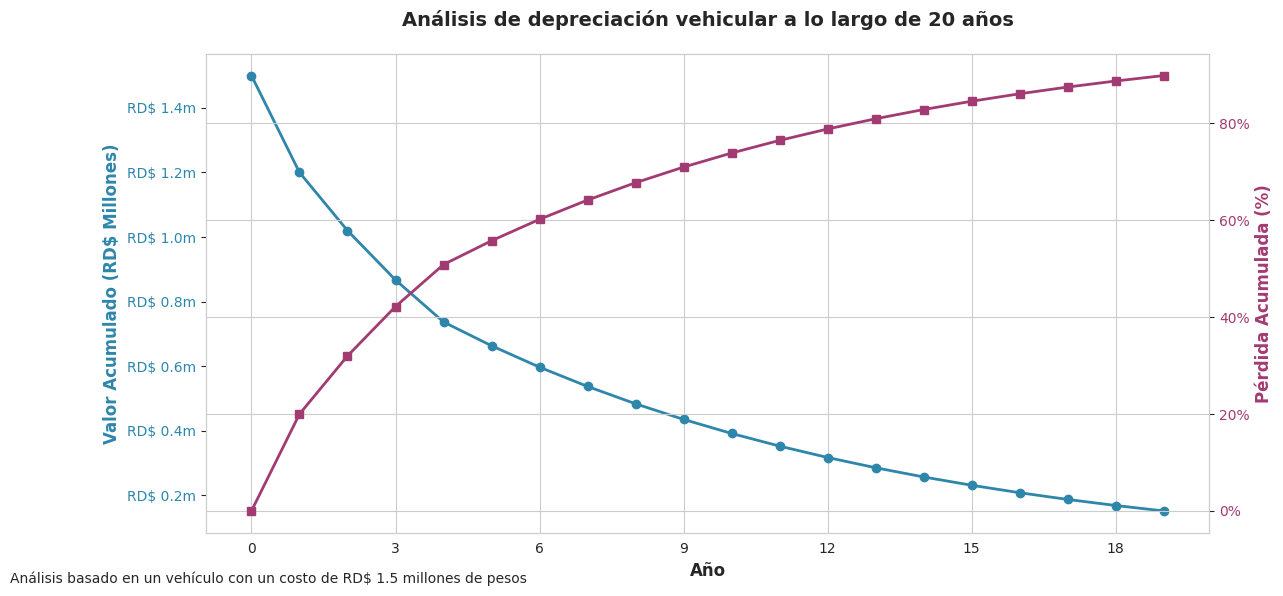

In [103]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(12, 6))
sns.set_style("whitegrid")
sns.set_palette("husl")

# Primary y-axis: valor acumulado (in millions)
ax1.plot(q['año'], q['valor acumulado']/1_000_000, color='#2E86AB', marker='o', linewidth=2, label='valor acumulado')
ax1.set_xlabel('Año', fontsize=12, fontweight='bold')
ax1.set_ylabel('Valor Acumulado (RD$ Millones)', color='#2E86AB', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#2E86AB')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'RD$ {x:.1f}m'))
ax1.grid(False, axis='y')

# Secondary y-axis: perdida acumulada %
ax2 = ax1.twinx()
ax2.plot(q['año'], q['perdida acumulada %']*100, color='#A23B72', marker='s', linewidth=2, label='perdida acumulada %')
ax2.set_ylabel('Pérdida Acumulada (%)', color='#A23B72', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#A23B72')
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(100))

# Format x-axis as integers
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.title('Análisis de depreciación vehicular a lo largo de 20 años', fontsize=14, fontweight='bold', pad=20)
plt.figtext(0.15, 0.02, 'Análisis basado en un vehículo con un costo de RD$ 1.5 millones de pesos', ha='center', fontsize=10)
fig.tight_layout()
plt.show()